In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer

In [3]:
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

Confusion matrix
We will use the confusion matrix function from sklearn to return the false positive, false negatives, true positives and true negatives, to construct the false negative rate.

TN | FP

FN | TP


**False Negative Rate**
Because it is a dangerous disease, I want to minimize the number of false negatives cases (the false negative rate). That is, I want to minimize the number of cases where the tumor in a patient is malign (1) and it is wrongly classified as benign (0). This way, we can offer treatment to as many patients as possible.

Because the False Negative Rate is not a metric available in sklearn, we need to create a function ourselves.

We will use the make_scorer function from sklearn:

In [5]:
# function returns the FNR given probabilities and the 
# grand truth

def fnr(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    
    FNR = fn / (tp + fn)
    
    return FNR


In [6]:
fnr_score = make_scorer(
    fnr,
    greater_is_better=False, # smaller is better
    needs_proba=False,
)

In [7]:
# random forests
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring=fnr_score,
                   cv=5)

search = clf.fit(X, y)

# best hyperparameters
search.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [8]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.164563,0.068712
1,"{'max_depth': 1, 'n_estimators': 20}",-0.159801,0.073267
2,"{'max_depth': 1, 'n_estimators': 50}",-0.178627,0.068895
3,"{'max_depth': 1, 'n_estimators': 100}",-0.145404,0.085822
4,"{'max_depth': 1, 'n_estimators': 200}",-0.140642,0.082462


Text(0.5, 0, 'Hyperparameter space')

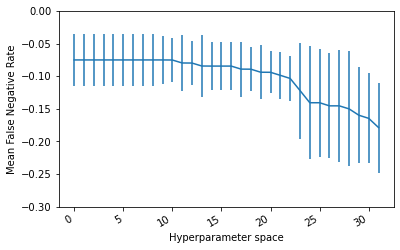

In [9]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylim(-0.3, 0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')

## Scoring Function that needs a probability

In [10]:
def fnr(y_true, y_pred):
    
    y_pred_class = np.where(y_pred > 0.37, 1, 0)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class, labels=[0,1]).ravel()
    
    FNR = fn / (tp + fn)
    
    return FNR

In [11]:
fnr_score = make_scorer(
    fnr,
    greater_is_better=False, # smaller is better
    needs_proba=True,
)

In [12]:
# random forests
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring=fnr_score,
                   cv=5)

search = clf.fit(X, y)

# best hyperparameters
search.best_params_

{'max_depth': 4, 'n_estimators': 500}

Text(0.5, 0, 'Hyperparameter space')

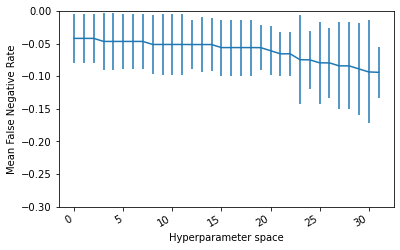

In [13]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylim(-0.3, 0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')

## Optimizing a performance metric given by sklearn

https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

In [15]:
# random forests
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# search
clf = GridSearchCV(rf_model,
                   rf_param_grid,
                   scoring='roc_auc',
                   cv=5)

search = clf.fit(X, y)

# best hyperparameters
search.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [16]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",0.976634,0.018081
1,"{'max_depth': 1, 'n_estimators': 20}",0.982221,0.014463
2,"{'max_depth': 1, 'n_estimators': 50}",0.984714,0.010529
3,"{'max_depth': 1, 'n_estimators': 100}",0.985032,0.009164
4,"{'max_depth': 1, 'n_estimators': 200}",0.984932,0.009091


Text(0.5, 0, 'Hyperparameter space')

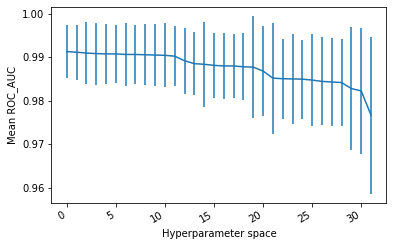

In [17]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean ROC_AUC')
plt.xlabel('Hyperparameter space')